## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [80]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-842ynibt
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-842ynibt
  Created wheel for tensorflow-examples: filename=tensorflow_examples-8447685790fc20609de3ee49e525a479e44b1ada_-cp36-none-any.whl size=130369 sha256=0336cdfd84a354638dc7d821096528b78eedd685bb6854a139e42eecfb7fac12
  Stored in directory: /tmp/pip-ephem-wheel-cache-30_a93az/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [139]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import IPython.display as display
from PIL import Image
import numpy as np
import pathlib


tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from SEM images, to segmented images. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [141]:
# data path 
path_image = 'drive/My Drive/Course/CS230/CycleGAN/img_v2'
path_label = 'drive/My Drive/Course/CS230/CycleGAN/lbl_v3'

# data names
im_list = os.listdir(path_image)
la_list = os.listdir(path_label)

# data full path
image_list = [os.path.join(path_image, ele) for ele in im_list]
label_list = [os.path.join(path_label, ele) for ele in la_list]

# manual split
image_list_train = image_list[:40]
label_list_train = label_list[:40]
image_list_test = image_list[25:]
label_list_test = label_list[25:]

# convert to tensor
image_list_train_tf = tf.constant(image_list_train)
label_list_train_tf = tf.constant(label_list_train)
image_list_test_tf = tf.constant(image_list_test)
label_list_test_tf = tf.constant(label_list_test)

# print length
print(len(image_list_train))
print(len(label_list_train))
print(len(image_list_test))
print(len(label_list_test))

40
33
27
8


In [0]:
BUFFER_SIZE = 25
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
####
def random_crop_images(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_WIDTH, IMG_HEIGHT, 3])
  return cropped_image

def random_crop_labels(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_WIDTH, IMG_HEIGHT, 3])
  return cropped_image

####
def random_jitter_images(image):
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop_images(image)
  image = tf.image.random_flip_left_right(image)
  return image

def random_jitter_labels(image):
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop_labels(image)
  image = tf.image.random_flip_left_right(image)
  return image

####
def decode_images(img):
  img = tf.image.decode_png(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def decode_labels(img):
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)*255.
  return img

####
def process_path_images_train(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_images(img)
  img = random_jitter_images(img)
  return img

def process_path_labels_train(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_labels(img)
  img = random_jitter_labels(img)
  return img

####
def process_path_images_test(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_images(img)
  return img

def process_path_labels_test(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_labels(img)
  return img

In [0]:
# dataset of string
image_train_ds = tf.data.Dataset.from_tensor_slices(image_list_train_tf)
label_train_ds = tf.data.Dataset.from_tensor_slices(label_list_train_tf)
image_test_ds = tf.data.Dataset.from_tensor_slices(image_list_test_tf)
label_test_ds = tf.data.Dataset.from_tensor_slices(label_list_test_tf)

# dataset map to arrays
image_train_ds = image_train_ds.map(process_path_images_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
label_train_ds = label_train_ds.map(process_path_labels_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
"""
what is the optimal buffer size for test data???
"""
image_test_ds = image_test_ds.map(process_path_images_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
label_test_ds = label_test_ds.map(process_path_labels_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [145]:
sample_image = next(iter(image_train_ds))
sample_label = next(iter(label_train_ds))
print(sample_image.shape)
print(sample_label.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


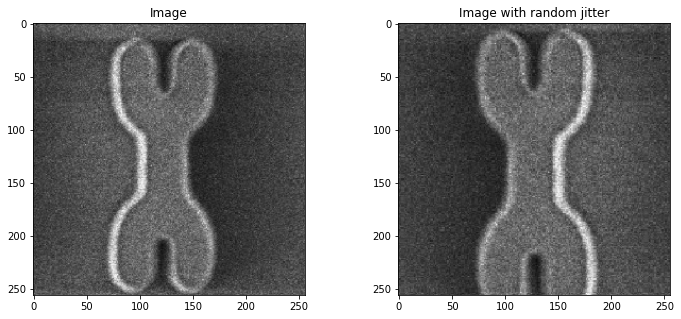

In [146]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Image')
plt.imshow(sample_image[0])

plt.subplot(122)
plt.title('Image with random jitter')
plt.imshow(random_jitter_images(sample_image[0]))

In [0]:
sample_label = next(iter(label_train_ds))

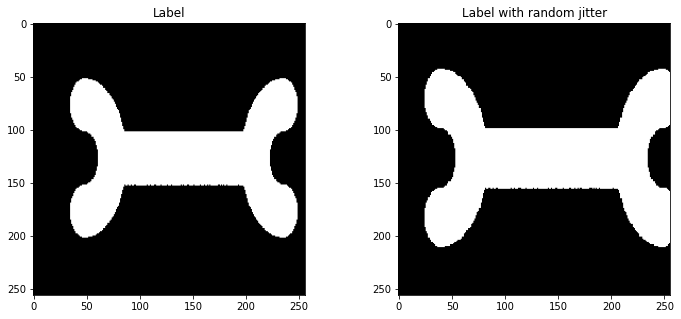

In [148]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Label')
plt.imshow(sample_label[0,:,:,:])

plt.subplot(122)
plt.title('Label with random jitter')
plt.imshow(random_jitter_labels(sample_label[0]))

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [0]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


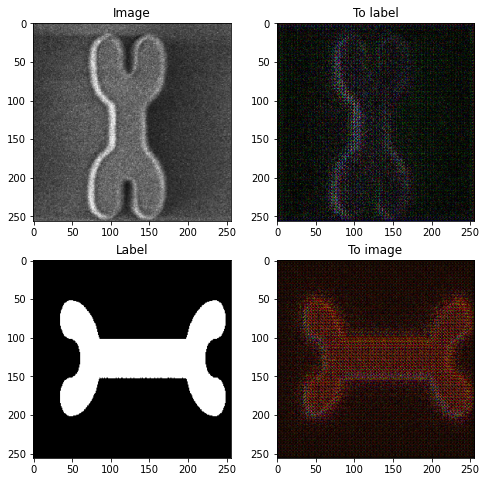

In [150]:
to_label = generator_g(sample_image)
to_image = generator_f(sample_label)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_image, to_label, sample_label, to_image]
title = ['Image', 'To label', 'Label', 'To image']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0])
  else:
    plt.imshow(imgs[i][0])
plt.show()

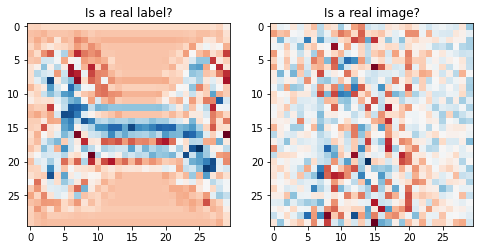

In [151]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real label?')
plt.imshow(discriminator_y(sample_label)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real image?')
plt.imshow(discriminator_x(sample_image)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in pix2pix.



In [0]:
LAMBDA = 10

In [0]:
#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = tf.keras.losses.MeanSquaredError()

In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [0]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [0]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [0]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints



In [171]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [0]:
EPOCHS = 40

In [0]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [0]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    #same_x = generator_f(real_x, training=True)
    #same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    #total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    #total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    total_gen_g_loss = gen_g_loss + total_cycle_loss 
    total_gen_f_loss = gen_f_loss + total_cycle_loss 

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


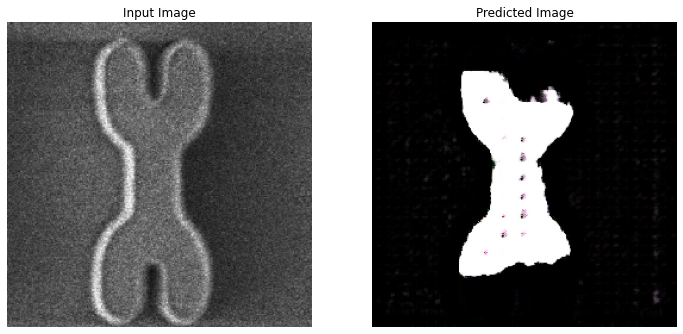

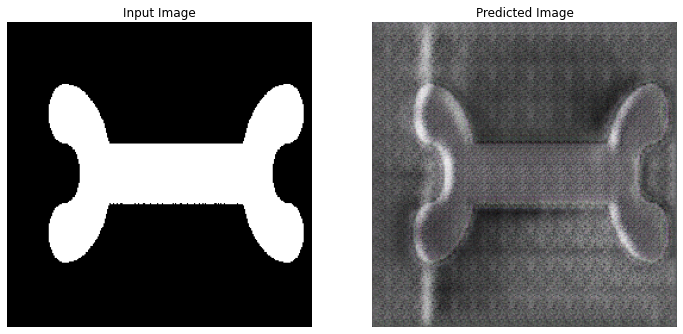

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-76
Time taken for epoch 40 is 15.77135968208313 sec



In [163]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((image_train_ds, label_train_ds)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_image)
  generate_images(generator_f, sample_label)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

In [175]:
# Run the trained model on the test dataset
for inp in image_train_ds.take(10):
  generate_images(generator_g, inp)

Output hidden; open in https://colab.research.google.com to view.

In [176]:
for inp in label_train_ds.take(10):
  generate_images(generator_f, inp)

Output hidden; open in https://colab.research.google.com to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


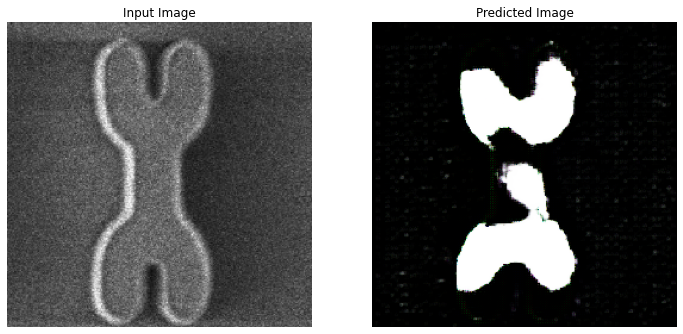

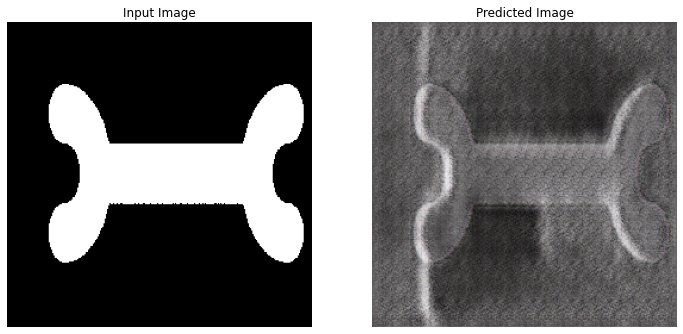

Saving checkpoint for epoch 200 at ./checkpoints/train/ckpt-108
Time taken for epoch 200 is 16.083254098892212 sec



In [174]:
for epoch in range(100,200):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((image_train_ds, label_train_ds)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_image)
  generate_images(generator_f, sample_label)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [0]:
lr = tf.keras.optimizers.schedules.PolynomialDecay(
    2e-4, 100, end_learning_rate=0, power=1.0,
    cycle=False, name=None
)

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)